In [180]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import catboost as cb
import optuna
from optuna.integration import CatBoostPruningCallback
import warnings
warnings.filterwarnings('ignore')

In [181]:
train_data = pd.read_csv('../data/raw/sales_ads_train.csv')
test_data = pd.read_csv('../data/raw/sales_ads_test.csv')

In [182]:
train_data.shape

(135397, 25)

In [183]:
test_data.shape

(72907, 24)

In [184]:
test_ids = test_data['ID'].values
train_data['is_train'] = 1
test_data['is_train'] = 0
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
all_data['log_Cena'] = np.log1p(all_data['Cena'])

In [185]:
current_year = datetime.now().year
all_data['Wiek_pojazdu'] = current_year - all_data['Rok_produkcji']
all_data

,ID,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,...,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,is_train,log_Cena,Wiek_pojazdu
0,1,13900.0,PLN,Used,Renault,Grand Espace,Gr 2.0T 16V Expression,NaN,2005.0,213000.0,...,blue,NaN,NaN,NaN,28/04/2021,"SŁONECZNA 1 - 99-300 Kutno, kutnowski, Łódzkie...","['ABS', 'Electric front windows', 'Drivers air...",1,9.539716,20.0
1,2,25900.0,PLN,Used,Renault,Megane,1.6 16V 110,III (2008-2016),2010.0,117089.0,...,silver,NaN,NaN,16/06/2010,04/05/2021,"ul. Wiosenna 8 - 41-407 Imielin, Centrum (Polska)","['ABS', 'Electric front windows', 'Drivers air...",1,10.162037,15.0
2,3,35900.0,PLN,Used,Opel,Zafira,Tourer 1.6 CDTI ecoFLEX Start/Stop,C (2011-2019),2015.0,115600.0,...,white,Denmark,NaN,NaN,03/05/2021,"Sianów, koszaliński, Zachodniopomorskie","['ABS', 'Electric front windows', 'Passengers ...",1,10.488520,10.0
3,4,5999.0,PLN,Used,Ford,Focus,1.6 TDCi FX Silver / Silver X,Mk2 (2004-2011),2007.0,218000.0,...,blue,NaN,NaN,27/11/2007,02/05/2021,"Gdańsk, Pomorskie, Przymorze Wielkie","['ABS', 'Electric front windows', 'Drivers air...",1,8.699515,18.0
4,5,44800.0,PLN,Used,Toyota,Avensis,1.8,III (2009-),2013.0,NaN,...,other,Poland,Yes,20/05/2013,02/05/2021,"Świdnik, świdnicki, Lubelskie","['ABS', 'Electric front windows', 'Drivers air...",1,10.709986,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208299,72903,NaN,PLN,Used,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,II (2016-),2016.0,53000.0,...,black,Poland,Yes,20/12/2020,29/04/2021,"Sąsiedzka 4 - 03-168 Warszawa, Białołęka (Polska)","['ABS', 'Electric front windows', 'Drivers air...",0,NaN,9.0
208300,72904,NaN,PLN,Used,Ford,Kuga,2.0 TDCi Trend,I (2008-2012),2009.0,188132.0,...,black,Germany,NaN,NaN,30/04/2021,ul. Małkińska 184 (między CPN a stacją kontrol...,"['ABS', 'Rain sensor', 'Electric front windows...",0,NaN,16.0
208301,72905,NaN,PLN,Used,Toyota,Avensis,NaN,III (2009-),2016.0,76786.0,...,blue,Poland,Yes,NaN,29/04/2021,ALEJA WOJSKA POLSKIEGO 68/76 - 42-200 Częstoch...,"['ABS', 'Lane assistant', 'Central locking', '...",0,NaN,9.0
208302,72906,NaN,PLN,Used,Renault,Trafic,2.0 dCi 115 Combi L1H1,II (2001-2014),2009.0,204300.0,...,blue,NaN,NaN,NaN,01/05/2021,Gaj ( 3km Od Krakowa Przy Zakopiance)Myślenick...,"['ABS', 'Electric front windows', 'Drivers air...",0,NaN,16.0


In [186]:
all_data['log_Przebieg_km'] = np.log1p(all_data['Przebieg_km'])

In [187]:
all_data['Efektywnosc_silnika'] = all_data['Moc_KM'] / (all_data['Pojemnosc_cm3'] / 1000)  # moc na litr
all_data['Efektywnosc_silnika'].replace([np.inf, -np.inf], np.nan, inplace=True)
all_data['Efektywnosc_silnika'] = all_data['Efektywnosc_silnika'].fillna(all_data['Efektywnosc_silnika'].median())

In [188]:
all_data['Sredni_roczny_przebieg'] = all_data['Przebieg_km'] / all_data['Wiek_pojazdu'].replace(0, 0.5)
all_data['Sredni_roczny_przebieg'].replace([np.inf, -np.inf], np.nan, inplace=True)
all_data['Sredni_roczny_przebieg'] = all_data['Sredni_roczny_przebieg'].fillna(all_data['Sredni_roczny_przebieg'].median())

In [189]:
if 'Wyposazenie' in all_data.columns:
    if isinstance(all_data['Wyposazenie'].iloc[0], str):
        all_data['Wyposazenie'] = all_data['Wyposazenie'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [])
    all_data['Liczba_elementow_wyposazenia'] = all_data['Wyposazenie'].apply(len)

    premium_features = ['Leather upholstery', 'GPS navigation', 'Heated front seats', 
                         'Xenon lights', 'LED lights', 'Automatic air conditioning']
    for feature in premium_features:
        all_data[f'ma_{feature.replace(" ", "_")}'] = all_data['Wyposazenie'].apply(
            lambda x: 1 if isinstance(x, list) and any(feature in item for item in x) else 0
        )

In [190]:
numeric_cols = ['Rok_produkcji', 'Przebieg_km', 'Moc_KM', 'Pojemnosc_cm3', 
                'Liczba_drzwi', 'Liczba_elementow_wyposazenia', 'Efektywnosc_silnika']
for col in numeric_cols:
    if col in all_data.columns and all_data[col].isnull().sum() > 0:
        all_data[col] = all_data[col].fillna(all_data.loc[all_data['is_train'] == 1, col].median())


In [191]:
categorical_cols = ['Stan', 'Marka_pojazdu', 'Model_pojazdu', 'Rodzaj_paliwa', 
                   'Naped', 'Skrzynia_biegow', 'Typ_nadwozia', 'Kolor', 'Kraj_pochodzenia']
for col in categorical_cols:
    if col in all_data.columns and all_data[col].isnull().sum() > 0:
        all_data[col] = all_data[col].fillna('nieznany')

In [192]:
train_marka_mean_price = all_data.loc[all_data['is_train'] == 1].groupby('Marka_pojazdu')['log_Cena'].mean()
all_data['Marka_avg_price'] = all_data['Marka_pojazdu'].map(train_marka_mean_price)

In [193]:
all_data['Marka_avg_price'] = all_data['Marka_avg_price'].fillna(train_marka_mean_price.mean())

In [194]:
train_model_mean_price = all_data.loc[all_data['is_train'] == 1].groupby(['Marka_pojazdu', 'Model_pojazdu'])['log_Cena'].mean()
all_data['Model_avg_price'] = all_data.apply(lambda x: train_model_mean_price.get((x['Marka_pojazdu'], x['Model_pojazdu']), np.nan), axis=1)

In [195]:
all_data['Model_avg_price'] = all_data['Model_avg_price'].fillna(all_data['Marka_avg_price'])

In [196]:
color_counts = all_data['Kolor'].value_counts(normalize=True)
all_data['Kolor_freq'] = all_data['Kolor'].map(color_counts)

In [197]:
all_data_encoded = pd.get_dummies(all_data, columns=['Stan', 'Rodzaj_paliwa', 'Naped', 
                                         'Skrzynia_biegow', 'Typ_nadwozia'])

In [198]:
features = [
    'Wiek_pojazdu', 'log_Przebieg_km', 'Moc_KM', 'Pojemnosc_cm3', 
    'Liczba_elementow_wyposazenia', 'Efektywnosc_silnika', 'Sredni_roczny_przebieg',
    
    'Marka_avg_price', 'Model_avg_price', 'Kolor_freq',
    
    'ma_Leather_upholstery', 'ma_GPS_navigation', 'ma_Heated_front_seats',
    'ma_Xenon_lights', 'ma_LED_lights', 'ma_Automatic_air_conditioning'
]

features += [col for col in all_data_encoded.columns if col.startswith(('Stan_', 'Rodzaj_paliwa_', 
                                                               'Naped_', 'Skrzynia_biegow_', 'Typ_nadwozia_'))]
X_all = all_data_encoded[features].copy()
X_all

,Wiek_pojazdu,log_Przebieg_km,Moc_KM,Pojemnosc_cm3,Liczba_elementow_wyposazenia,Efektywnosc_silnika,Sredni_roczny_przebieg,Marka_avg_price,Model_avg_price,Kolor_freq,...,Typ_nadwozia_SUV,Typ_nadwozia_city_cars,Typ_nadwozia_compact,Typ_nadwozia_convertible,Typ_nadwozia_coupe,Typ_nadwozia_minivan,Typ_nadwozia_nieznany,Typ_nadwozia_sedan,Typ_nadwozia_small_cars,Typ_nadwozia_station_wagon
0,20.0,12.269052,170.0,1998.0,18,85.085085,10650.000000,10.053987,9.695962,0.102494,...,False,False,False,False,False,True,False,False,False,False
1,15.0,11.670698,110.0,1598.0,27,68.836045,7805.933333,10.053987,10.122849,0.145921,...,False,False,False,False,False,False,False,False,False,True
2,10.0,11.657900,136.0,1598.0,24,85.106383,11560.000000,10.045032,9.841850,0.143641,...,False,False,False,False,False,True,False,False,False,False
3,18.0,12.292255,90.0,1560.0,17,57.692308,12111.111111,10.352441,10.049870,0.102494,...,False,False,True,False,False,False,False,False,False,False
4,12.0,NaN,136.0,1798.0,25,75.093867,10066.666667,10.460586,10.205401,0.065280,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208299,9.0,10.878066,220.0,1984.0,52,110.887097,5888.888889,10.385014,11.188347,0.237523,...,True,False,False,False,False,False,False,False,False,False
208300,16.0,12.144904,136.0,1997.0,35,68.102153,11758.250000,10.352441,11.019403,0.237523,...,True,False,False,False,False,False,False,False,False,False
208301,9.0,11.248791,143.0,1995.0,37,71.679198,8531.777778,10.460586,10.205401,0.102494,...,False,False,False,False,False,False,False,False,False,True
208302,16.0,12.227350,114.0,1995.0,11,57.142857,12768.750000,10.053987,10.662298,0.102494,...,False,False,False,False,False,True,False,False,False,False


In [199]:
missing = X_all.isnull().sum()
if missing.sum() > 0:
    print(f"Brakujące wartości w danych: {missing[missing > 0]}")
    for col in X_all.columns:
        if X_all[col].isnull().sum() > 0:
            if X_all[col].dtype.kind in 'ifc':
                X_all[col] = X_all[col].fillna(X_all.loc[all_data['is_train'] == 1, col].median())
            else:
                X_all[col] = X_all[col].fillna('nieznany')

Brakujące wartości w danych: Wiek_pojazdu       3407
log_Przebieg_km    4333
dtype: int64


In [200]:
X_train = X_all[all_data['is_train'] == 1]
y_train = all_data.loc[all_data['is_train'] == 1, 'log_Cena']
X_test = X_all[all_data['is_train'] == 0]

In [201]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [202]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "verbose": False,
        "random_seed": 42
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    log_rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        pruning_callback = CatBoostPruningCallback(trial, "RMSE")
        
        model = cb.CatBoostRegressor(**param)
        model.fit(
            X_train_fold, 
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[pruning_callback],
            early_stopping_rounds=100,
            verbose=0
        )
        
        y_val_pred_log = model.predict(X_val_fold)
        
        log_rmse = calculate_rmse(y_val_fold, y_val_pred_log)
        log_rmse_scores.append(log_rmse)
    
    return np.mean(log_rmse_scores)

In [203]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    sampler=optuna.samplers.TPESampler(seed=42)
)

n_trials = 100
study.optimize(objective, n_trials=n_trials)

[I 2025-03-22 10:36:29,293] A new study created in memory with name: no-name-eaaa0b87-69a0-406c-9511-489d542302e6
[I 2025-03-22 10:36:50,467] Trial 0 finished with value: 0.26022646505917213 and parameters: {'iterations': 1436, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 0.0024430162614261413, 'random_strength': 2.5361081166471375e-07, 'bagging_temperature': 1.5599452033620265, 'border_count': 45, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.26022646505917213.
[I 2025-03-22 10:37:33,036] Trial 1 finished with value: 0.26105011034396286 and parameters: {'iterations': 2003, 'learning_rate': 0.11114989443094977, 'depth': 4, 'l2_leaf_reg': 5.360294728728285, 'random_strength': 0.31044435499483225, 'bagging_temperature': 2.1233911067827616, 'border_count': 72, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.26022646505917213.
[I 2025-03-22 10:38:08,790] Trial 2 finished with value: 0.2564613424400939 and parameters: {'iterations': 1260, 'learning_rate': 

In [204]:
optuna_history = {
    'Numer próby': list(range(1, len(study.trials) + 1)),
    'RMSE': [t.value for t in study.trials]
}

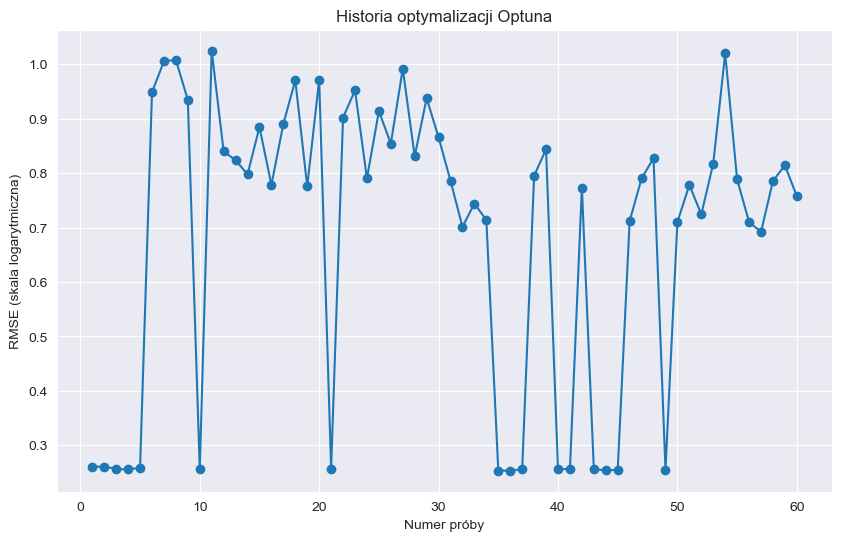

In [205]:
plt.figure(figsize=(10, 6))
plt.plot(optuna_history['Numer próby'], optuna_history['RMSE'], marker='o')
plt.title('Historia optymalizacji Optuna')
plt.xlabel('Numer próby')
plt.ylabel('RMSE (skala logarytmiczna)')
plt.grid(True)

In [206]:
param_importance = optuna.importance.get_param_importances(study)
importance_df = pd.DataFrame(list(param_importance.items()), columns=['Parameter', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

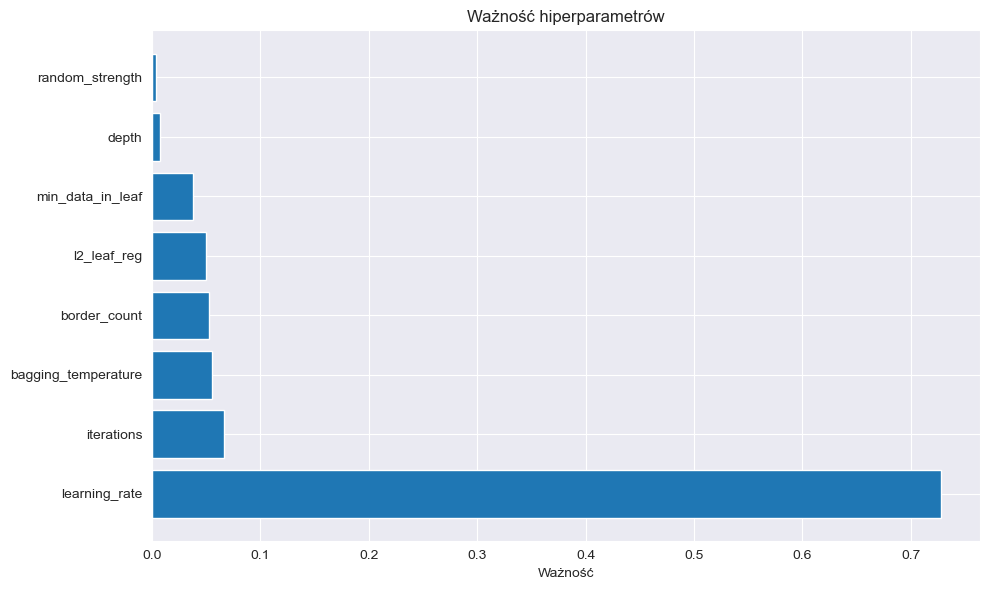

In [207]:

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Parameter'], importance_df['Importance'])
plt.title('Ważność hiperparametrów')
plt.xlabel('Ważność')
plt.tight_layout()

In [208]:
best_params = study.best_params
best_params['verbose'] = 0 
final_model = cb.CatBoostRegressor(**best_params)

In [209]:
final_model.fit(X_train, y_train)

In [210]:
y_pred_log = final_model.predict(X_test)

In [211]:
y_pred = np.expm1(y_pred_log)

In [212]:
submission = pd.DataFrame({
    'ID': test_ids,
    'Cena': y_pred
})

submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

In [213]:
submission['Cena'].describe()

count    7.290700e+04
mean     6.208594e+04
std      8.084227e+04
min      1.262900e+03
25%      1.774071e+04
50%      3.544199e+04
75%      7.531295e+04
max      2.416176e+06
Name: Cena, dtype: float64

Text(0, 0.5, 'Liczba samochodów')

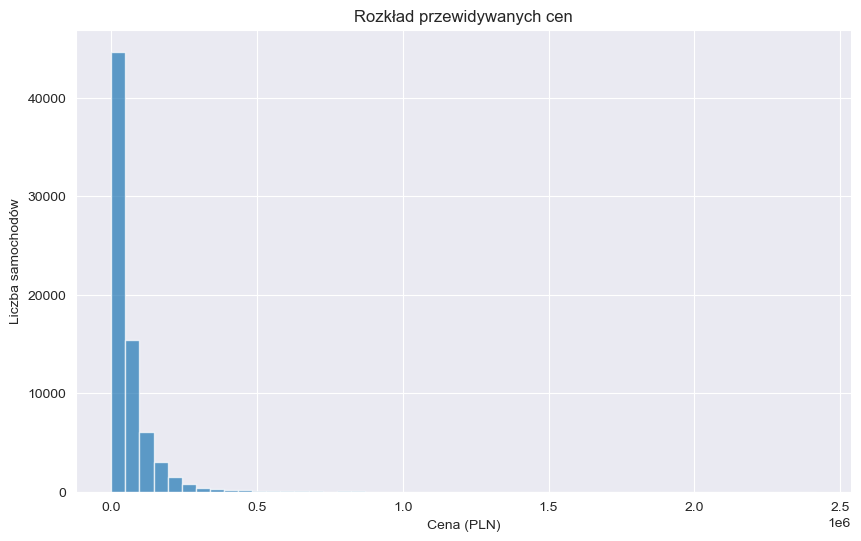

In [214]:

plt.figure(figsize=(10, 6))
plt.hist(submission['Cena'], bins=50, alpha=0.7)
plt.title('Rozkład przewidywanych cen')
plt.xlabel('Cena (PLN)')
plt.ylabel('Liczba samochodów')

In [215]:
feature_importance = final_model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).head(20)

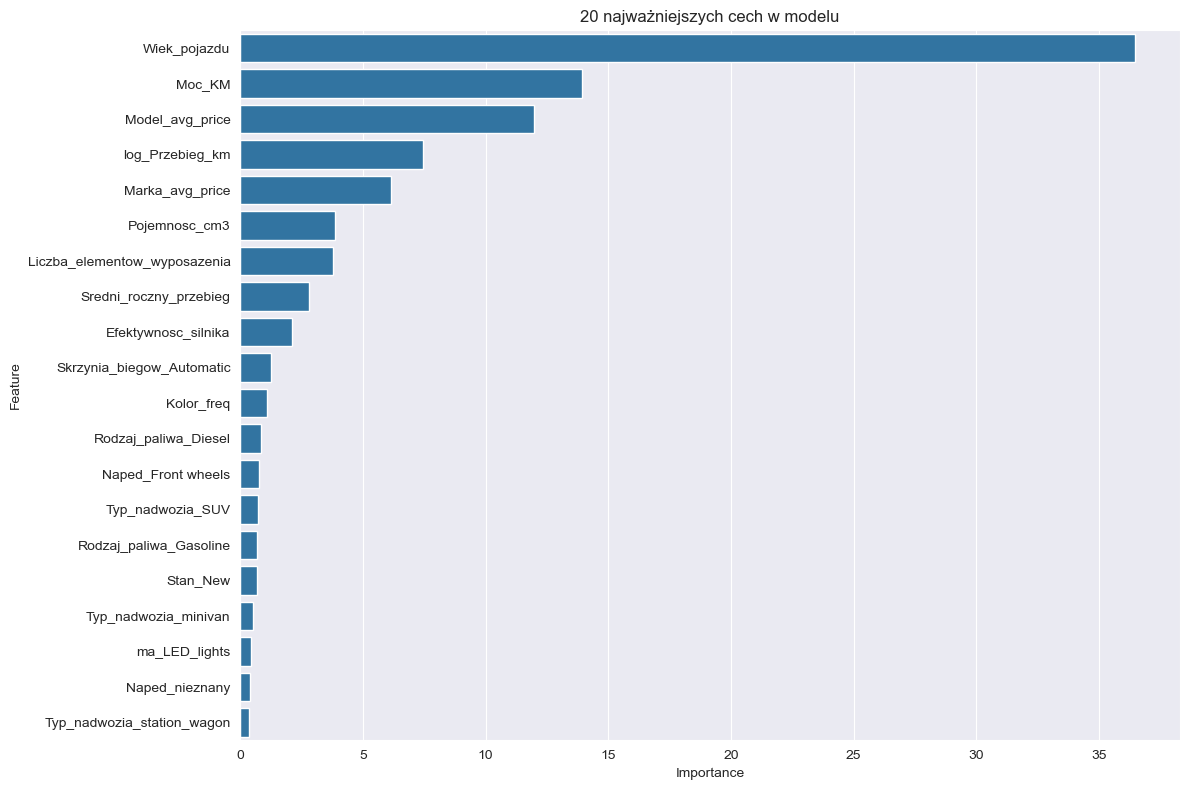

In [216]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('20 najważniejszych cech w modelu')
plt.tight_layout()

In [217]:
print(f"Najlepszy RMSE z Optuny (skala logarytmiczna): {study.best_value:.6f}")

Najlepszy RMSE z Optuny (skala logarytmiczna): 0.253318


## Najlepszy RMSE z Optuny (skala logarytmiczna): 0.253318

In [218]:
from xgboost import XGBRegressor

In [219]:
def objective_xgboost(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        "random_state": 42,
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = XGBRegressor(**param)
        model.fit(X_train_fold, y_train_fold)
        
        y_val_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

In [220]:
study_xgboost = optuna.create_study(direction="minimize")
study_xgboost.optimize(objective_xgboost, n_trials=100)

[I 2025-03-22 10:47:36,299] A new study created in memory with name: no-name-363e2175-e087-4c33-8ef5-56b12c0d68d6
[I 2025-03-22 10:47:46,501] Trial 0 finished with value: 0.2657422686916708 and parameters: {'n_estimators': 1720, 'learning_rate': 0.13111798770826197, 'max_depth': 7, 'subsample': 0.755245081687002, 'colsample_bytree': 0.7684307270811245, 'gamma': 0.6700447594052736, 'reg_alpha': 0.6894912214175407, 'reg_lambda': 0.9275571913296381}. Best is trial 0 with value: 0.2657422686916708.
[I 2025-03-22 10:47:57,780] Trial 1 finished with value: 0.2606361272505736 and parameters: {'n_estimators': 1296, 'learning_rate': 0.03167312699133322, 'max_depth': 9, 'subsample': 0.8019704153822468, 'colsample_bytree': 0.7285335933940985, 'gamma': 0.6441792543758053, 'reg_alpha': 0.8230638068315379, 'reg_lambda': 0.9687140643435183}. Best is trial 1 with value: 0.2606361272505736.
[I 2025-03-22 10:48:10,036] Trial 2 finished with value: 0.2627901132443009 and parameters: {'n_estimators': 1871

In [221]:
best_params_xgboost = study_xgboost.best_params
print("Najlepsze hiperparametry XGBoost:", best_params_xgboost)

Najlepsze hiperparametry XGBoost: {'n_estimators': 977, 'learning_rate': 0.02759408208117173, 'max_depth': 10, 'subsample': 0.927902608725046, 'colsample_bytree': 0.6001825813953219, 'gamma': 0.0015311538254383205, 'reg_alpha': 0.749383484113176, 'reg_lambda': 0.43256189820704377}


In [224]:
xgboost_model = XGBRegressor(**best_params_xgboost, random_state=42)
xgboost_model.fit(X_train, y_train)
print(f"Najlepszy RMSE z Optuny XGBoost (skala logarytmiczna): {study_xgboost.best_value:.6f}")

Najlepszy RMSE z Optuny XGBoost (skala logarytmiczna): 0.247977


### Najlepszy RMSE z Optuny XGBoost (skala logarytmiczna): 0.249434

In [225]:
weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_weight = 0.5
best_rmse = float('inf')

for w in weights:
    ensemble_rmse_cv = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        catboost_model = cb.CatBoostRegressor(**best_params)
        catboost_model.fit(X_train_fold, y_train_fold)
        
        xgboost_model = XGBRegressor(**best_params_xgboost, random_state=42)
        xgboost_model.fit(X_train_fold, y_train_fold)
        
        y_val_pred_catboost = catboost_model.predict(X_val_fold)
        y_val_pred_xgboost = xgboost_model.predict(X_val_fold)
        
        y_val_pred_weighted = w * y_val_pred_catboost + (1-w) * y_val_pred_xgboost
        
        ensemble_rmse_cv.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred_weighted)))
    
    mean_rmse = np.mean(ensemble_rmse_cv)
    print(f"Waga CatBoost: {w:.1f}, Średni RMSE: {mean_rmse:.6f}")
    
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_weight = w

print(f"Najlepsza waga dla CatBoost: {best_weight:.1f} z RMSE: {best_rmse:.6f}")

Waga CatBoost: 0.1, Średni RMSE: 0.247456
Waga CatBoost: 0.2, Średni RMSE: 0.247192
Waga CatBoost: 0.3, Średni RMSE: 0.247186
Waga CatBoost: 0.4, Średni RMSE: 0.247436
Waga CatBoost: 0.5, Średni RMSE: 0.247943
Waga CatBoost: 0.6, Średni RMSE: 0.248705
Waga CatBoost: 0.7, Średni RMSE: 0.249719
Waga CatBoost: 0.8, Średni RMSE: 0.250982
Waga CatBoost: 0.9, Średni RMSE: 0.252492
Najlepsza waga dla CatBoost: 0.3 z RMSE: 0.247186


In [226]:
final_catboost_model = cb.CatBoostRegressor(**best_params)
final_catboost_model.fit(X_train, y_train)

final_xgboost_model = XGBRegressor(**best_params_xgboost, random_state=42)
final_xgboost_model.fit(X_train, y_train)

y_pred_catboost = final_catboost_model.predict(X_test)
y_pred_xgboost = final_xgboost_model.predict(X_test)

y_pred_weighted_ensemble = best_weight * y_pred_catboost + (1-best_weight) * y_pred_xgboost

y_pred_weighted_ensemble = np.expm1(y_pred_weighted_ensemble)

submission_weighted_ensemble = pd.DataFrame({
    'ID': test_ids,
    'Cena': y_pred_weighted_ensemble
})
submission_weighted_ensemble.to_csv('submission_weighted_ensemble.csv', index=False)

### Najlepsza waga dla CatBoost: 0.3 z RMSE: 0.248060